# Matrix Factorization 1

* 개인화 추천 시스템의 기본이 되는 Matrix Factoization 모델에 대해서 알아 봅니다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

## 상호작용(Iteraction)

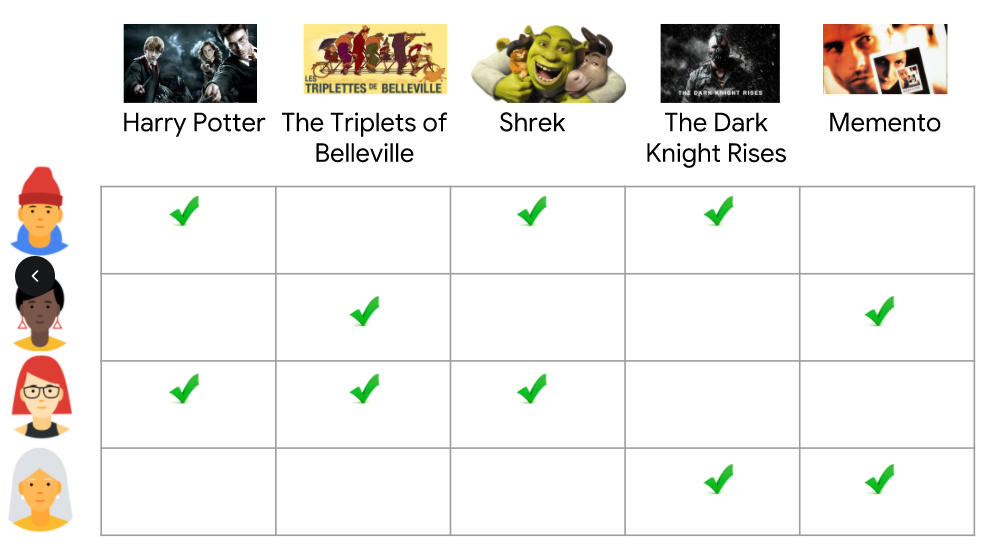

### 개인 취향

사람마다 영화에 대한 취향은 다릅니다. 1000만 관중을 동원한 액션 영화라도, 액션 영화 장르를 싫어 하는 사람에게 추천한다면 호응을 얻기 어렵겠죠.

추천에서는 개인과 영화를 독립적이 아니고 상호 관련 있습니다. 상호 작용을 모델링 하는 것이 **문제의 핵심** 입니다.

### 상호 작용 행렬(Iteraction Matrix)

- 사용자 / 아이템 간의 반응을 테이블화 한 것이 바로 상호 작용 행렬이라고 합니다.

   예제) MovieLen 100K 데이터셋에서 Interaction Matrix를 만들어봅니다.

- 평졈 호불호가 분명한 영화 몇 개와 사용자 몇 명을 뽑아 상호 작용 행렬의 예를 들어 봅니다.

In [3]:
# 1990년대 유명하고 제목이 짧은 영화 몇 편 뽑습니다.
item_index = [1, 226, 96, 402, 69, 29]
df_movie.loc[df_movie.index.isin(item_index)]

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Batman Forever (1995),01-Jan-1995,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
69,Forrest Gump (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
96,Terminator 2: Judgment Day (1991),01-Jan-1991,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
226,Die Hard 2 (1990),01-Jan-1990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
402,Ghost (1990),01-Jan-1990,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [4]:
# 평점의 표준편차가 1이 넘고 선정한 영화를 3건 넘게 시청한 사용자 중 평점순으로 10명을 뽑습니다.
# 위에서 선정한 영화를 적어도 3편 넘게 본 10명의 사용자를 뽑습니다.
df_user.loc[
    df_ratings.groupby('user id').filter(
        lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
    )['user id'].value_counts().head(10).index
]

,age,gender,occupation,zip code
user id,,,,
405,22,F,healthcare,10019
13,47,M,educator,29206
276,21,M,student,95064
416,20,F,student,92626
303,19,M,student,14853
279,33,M,programmer,85251
846,27,M,lawyer,47130
7,57,M,administrator,91344
94,26,M,student,71457


In [5]:
user_index = df_ratings.groupby('user id').filter(
    lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
)['user id'].value_counts().head(10).index

# 피벗을 통해 사용자 × 영화로 구성된 상호작용행렬을 만듭니다.
df_interaction = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
].join(df_movie['movie title'], on='item id')\
.join(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1).rename('user'), on='user id')\
.pivot(index='user',  columns='movie title', values='rating').sort_index().sort_index(axis=1)
df_interaction

movie title,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user,,,,,,
19/M/student,2.0,4.0,5.0,4.0,5.0,5.0
20/F/student,2.0,4.0,4.0,5.0,4.0,5.0
21/M/student,3.0,4.0,4.0,3.0,5.0,5.0
22/F/healthcare,4.0,2.0,4.0,3.0,3.0,NaN
23/M/programmer,2.0,3.0,4.0,NaN,4.0,4.0
26/M/student,2.0,2.0,3.0,4.0,3.0,4.0
27/M/lawyer,2.0,4.0,5.0,NaN,4.0,NaN
33/M/programmer,2.0,4.0,NaN,NaN,4.0,3.0
47/M/educator,2.0,4.0,4.0,4.0,4.0,3.0


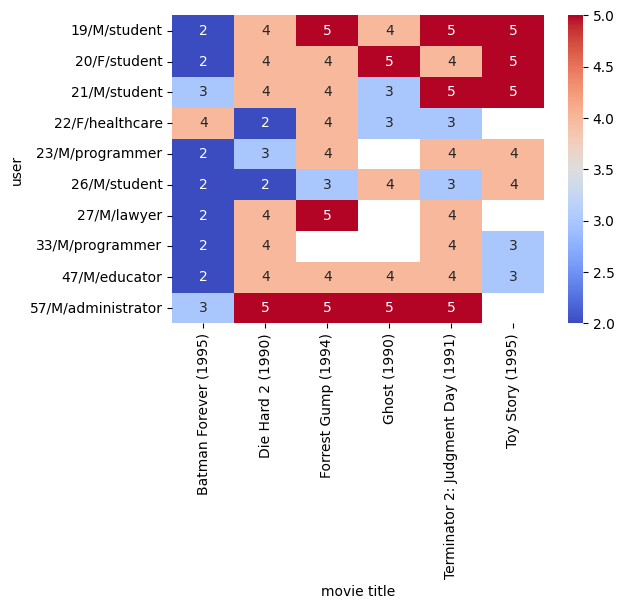

In [6]:
plt.figure(figsize=(6, 4))
cmap_coolwarm = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_interaction, cmap=cmap_coolwarm, annot=True)
plt.show()

# Matrix Factorization

상호작용을 모델링하기 위한 모델

- Sparsity가 큰 Sparse Matrix입니다.

- 크기는 User와 Item의 수의 곱의 관계입니다.

  한 명의 User가 증가하면 Item 수만큼 크기가 증가하고, 하나의 Item이 증가하면 User 만큼의 크기가 커집니다.

$N_{user}×N_{item}$의 상호작용 행렬(Matrix)을 

$N_{user}×Rank$사용자 행렬과 $N_{item}×Rank$아이템 행렬 두 개의 행렬곱으로 분해하는 모델입니다.

$Interaction = User × Item^T$

따라서, 한 명의 User가 증가하면 Rank 만큼, 하나의 Item이 증가하면 Rank 만큼 증가하여 User와 Item의 개수가 늘어나는 것이 둘 간의 곱으로 증가합니다.

> 영화의 수가 1000 개, 사용자의 수가 10000 명이라면 상호작용행렬로 각자의 특성을 나타낸다면
> 
> 1000 × 10000 = 10^7 개의 수가 필요합니다.
> 
> 하지만, 이를 Rank = 100 개인 두 개의 행렬로 나눈다면,
> 1000 × 100 + 10000 × 100 = 10^6 + 10^5 개의 수로 나타낼 수 있고
> 
> 줄어드는 크기는 영화와 사용자가 커질 수록 크개 나타납니다.

Rank와 User 수의 곱, Rank와 Item 수의 곱으로 증가합니다. 즉 선형적으로 증가 됩니다.

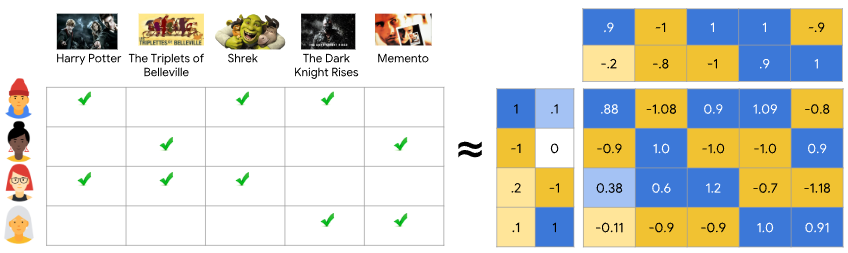


사용자 행렬: $N_{user}×Rank$ - 사용자 임베딩

아이템 행렬: $N_{item}×Rank$ - 아이템 임베딩

## 학습방법

### ALS(Alternating Least Square):

$Interaction = U × I^T$

MovieLens 100K에서 상호 작용은 영화에 대한 사용자의 평점 입니다. 

> $Rating_{ij} = U_i \cdot I_j$

사용자의 관점에서, 평점은 영화의 임베딩 에 대한 선형 관계라고 할 수 있고,

> $Rating_{ij} = I_j \cdot U_i$

영화의 관점에서, 평점은 사용자의 임베딩에 대한 선형 관계라고 할 수 있습니다.

이를 구하는 것을 선형 회귀 모델의 정규 방정식을 기반하에 구합는데, 

- 사용자의 임베딩은 아이템(영화)의 임베딩을 입력인 선형회귀모델의 학습을 통해 구합니다.

- 아이템(영화)의 임베딩은 사용자의 임베딩를 입력인 선형회귀모델의 학습을 통해 구합니다.

> (1) 사용자 / 아이템 임베딩 초기화
>
> (2-1) 사용자 임베딩 학습을 통해 업데이트
>
> (2-2) 아이템 임베딩 학습을 통해 업데이트
>
> (3) (2)과정 사용자의 임베딩과 아이템의 임베딩이 반복

In [7]:
# ALS를 Demo를 위한 위에서 보인 케이스만을 취합니다.
df_ratings_toy = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
]
df_ratings_toy.shape

(53, 4)

1. 사용자 / 아이템 임베딩 초기화

$(0, \frac{1}{\sqrt{Rank}})$ 사이의 임의의 실수로 초기화합니다. (ALS 논문의 내용)

In [8]:
# 사용자와 아이템 행렬의 랭크를 3으로 합니다.
Rank = 3
# 동일한 결과를 얻기 위해 랜덤 시드값을 지정합니다.
np.random.seed(123)
# (0, 1/(Rank ** 0.5)) 사이의 난수를 사용자와 아이템의 임베딩 초기값으로 설정합니다.
df_user_emb = pd.DataFrame(
    (np.random.random(size=(len(user_index), Rank))) * 1 / np.sqrt(Rank), index=user_index
)
df_item_emb = pd.DataFrame(
    (np.random.random(size=(len(item_index), Rank))) * 1 / np.sqrt(Rank), index=item_index
)
df_user_emb.shape, df_item_emb.shape

((10, 3), (6, 3))

2. 사용자 / 아이템 임베딩 학습

정규방정식을 이용하여 선형회귀모델을 학습시켜 계수를 구하여 임베딩을 업데이트 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [9]:
# 입력 Matrix와 대상 변수에 대한 선형회귀 모델의 계수를 반환합니다.
def lr_coef(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X)),
        np.dot(X.T, y)
    )

In [10]:
lr_coef(
    df_user_emb.loc[
        df_ratings_toy.loc[
            df_ratings_toy['item id'] == 69, 'user id'
        ]
    ], df_ratings_toy.loc[df_ratings_toy['item id'] == 69, 'rating']
)

array([ 5.7793186 , -2.98077025,  9.99594272])

In [11]:
# item id 별로 평가한 user id 의 임베딩을 df_user_emb에서 가져와서 입력 변수를 만들어 rating을 예측하는 
# OLS를 이용하여 선회회귀모델의 계수르 만듭니다.
df_ratings_toy.groupby('item id').apply(
    lambda x: pd.Series(
        lr_coef(
            df_user_emb.loc[x['user id']], x['rating']
        )
    ), include_groups = False
)

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [12]:
# 2-1 아이템 임베딩 학습

# OLS를 이용하여 아이템별 회귀계수를 구하여 df_item_emb_next 데이터프레임을 만듭니다.
df_item_emb_next = df_ratings_toy.groupby('item id').apply(
    lambda x: pd.Series(
        lr_coef(
            df_user_emb.loc[x['user id']], x['rating']
        )
    ), include_groups = False
)
# 변경의 정도를 파악하기 위해 업데이트한 아이템 임베딩과 이전 임베딩 간의 차이의 제곱을 구합니다.
item_emb_diff = np.sum(
    np.sum(
        np.square(df_item_emb - df_item_emb_next), axis=0
    ), axis=0)
# 업데이트 합니다.
df_item_emb = df_item_emb_next
df_item_emb

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [13]:
item_emb_diff

np.float64(728.5732918746372)

In [14]:
# 2-2 사용자 임베딩 업데이트 합니다.

df_user_emb_next = df_ratings_toy.groupby('user id').apply(
    lambda x: pd.Series(
        lr_coef(
            df_item_emb.loc[x['item id']], x['rating']
        )
    ), include_groups = False
)

user_emb_diff = ((df_user_emb - df_user_emb_next) ** 2).sum().sum()
df_user_emb = df_user_emb_next
df_user_emb

,0,1,2
user id,,,
7,0.516061,0.634194,0.392124
13,0.393520,0.678048,0.356878
94,0.099894,-0.136134,0.233914
276,0.574649,0.098999,0.131147
279,0.384026,0.682809,0.361387
303,0.353320,0.133474,0.298755
405,0.449600,-0.317001,0.013785
416,0.194407,0.213311,0.395661
682,0.276504,0.114749,0.256512


In [15]:
user_emb_diff

np.float64(1.187136115311858)

In [16]:
emb_diff = item_emb_diff + user_emb_diff
emb_diff

np.float64(729.7604279899491)

3. 2의 과정을 반복

In [17]:
# 1~3을 종합
from sklearn.metrics import mean_squared_error

# Step 1
Rank = 3
np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3: 10회 반복
for epoch in range(10):
    # Step 2
    #OLS를 이용하여 아이템별 회귀계수를 구합니다.
    df_item_emb_next = df_ratings_toy.groupby('item id').apply(
        lambda x: pd.Series(
            lr_coef(df_user_emb.loc[x['user id']], x['rating'])
        ), include_groups = False
    )
    item_emb_diff = np.sum(np.square(df_item_emb - df_item_emb_next), axis=0)
    df_item_emb = df_item_emb_next

    # 사용자 임베딩 학습
    df_user_emb_next = df_ratings_toy.groupby('user id').apply(
    lambda x: pd.Series(
            lr_coef(df_item_emb.loc[x['item id']], x['rating'])
        ), include_groups = False
    )
    user_emb_diff = np.sum(np.square(df_user_emb - df_user_emb_next), axis=0)
    df_user_emb = df_user_emb_next
    
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    emb_diff = np.sum(item_emb_diff + user_emb_diff, axis=0)
    print(epoch + 1, emb_diff, mse)

1 729.7604279899491 0.12188710594513749
2 4.559589375251532 0.06496126547005279
3 2.283052279308551 0.04633799138334469
4 0.524825469136112 0.04293589042320531
5 0.1739958952083807 0.042005196082754985
6 0.08226187257949148 0.041586486248460085
7 0.04671048983239096 0.04135132138443564
8 0.02950262608902558 0.041204441576543446
9 0.019966814732783493 0.041106424251441336
10 0.014189444200552468 0.04103777818252157


In [18]:
# Index에 MetaData를 가져옵니다.
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [19]:
df_user_emb

,0,1,2
user id,,,
57/M/administrator,0.454722,0.360233,0.362876
47/M/educator,0.341479,0.558217,0.359995
26/M/student,0.092114,-0.109913,0.238039
21/M/student,0.603429,0.332988,0.178285
33/M/programmer,0.465353,0.585146,0.266435
19/M/student,0.464728,0.371894,0.303228
22/F/healthcare,0.350740,-1.011812,-0.092194
20/F/student,0.224052,0.150768,0.357096
23/M/programmer,0.270347,0.220779,0.295905


In [20]:
df_item_emb

,0,1,2
item id,,,
Toy Story (1995),8.920902,-6.834619,10.771041
Batman Forever (1995),4.896305,-2.635868,4.299393
Forrest Gump (1994),5.861110,-2.707590,9.451070
Terminator 2: Judgment Day (1991),6.422984,-1.613685,8.022609
Die Hard 2 (1990),4.988968,-0.835978,7.543837
Ghost (1990),2.568718,-3.362181,13.855455


In [21]:
# 사용자별 아이템에 대한 평점 예측을 합니다.
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.598885,4.295124,4.582718,4.144746,4.817504,4.870125
20/F/student,2.234919,3.685626,4.279918,5.000000,4.060635,4.814602
21/M/student,2.843375,4.077067,4.320149,2.900688,4.768784,5.000000
22/F/healthcare,3.987955,1.900188,3.923967,3.025461,3.145909,5.000000
23/M/programmer,2.013967,3.396445,3.783372,4.052046,3.754096,4.090000
26/M/student,1.764157,2.347167,3.087213,3.904301,2.678706,4.136879
27/M/lawyer,1.975786,3.949472,5.000000,5.000000,4.048140,5.000000
33/M/programmer,1.881650,3.842404,3.661245,2.919574,4.182216,3.021898
47/M/educator,1.748359,3.952714,3.892360,3.988228,4.180627,3.108620


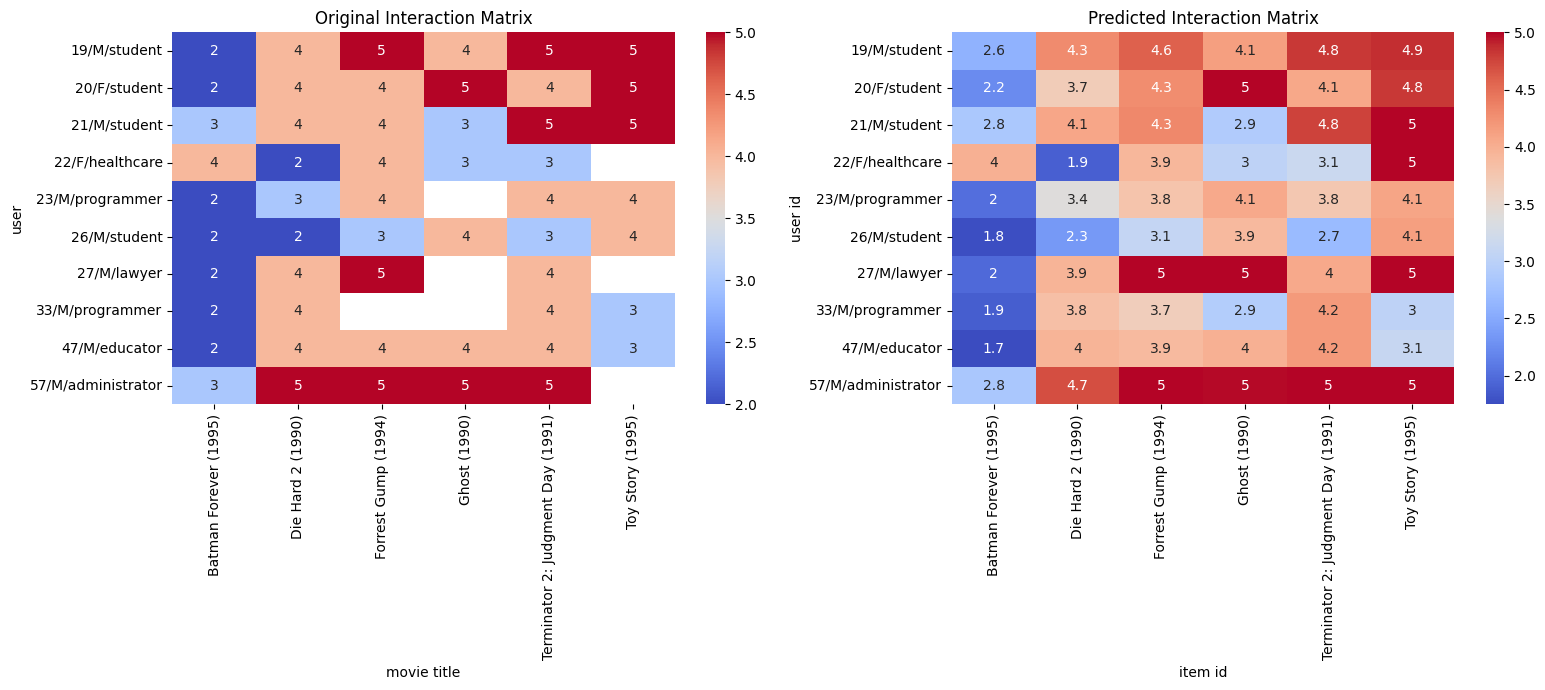

In [22]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

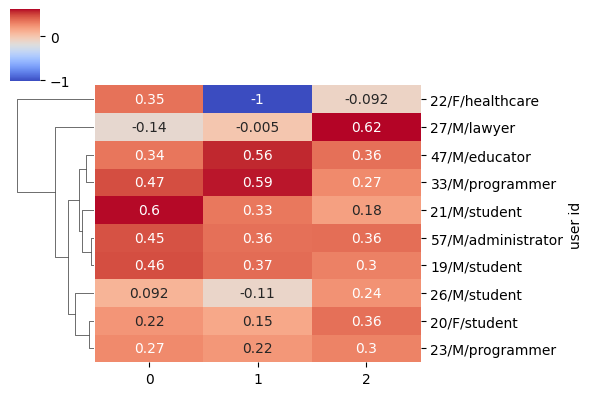

In [23]:
sns.clustermap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6,4),
)
plt.show()

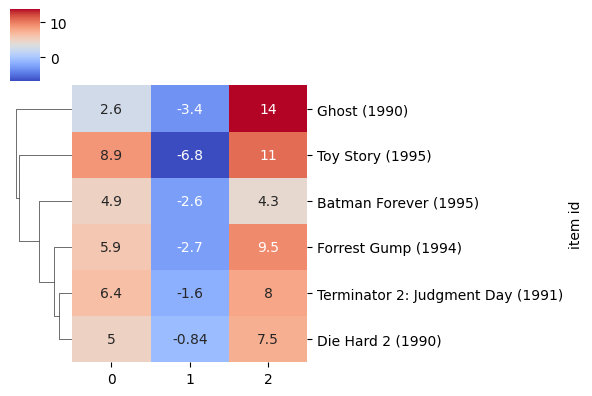

In [24]:
sns.clustermap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6, 4),
)
plt.show()

### 경사하강법(Gradient Descent)

$\hat{y} = User × Item^T$

$Loss(MSE) = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

$\frac{dLoss}{dUser_u} = -\frac{2}{n_u}\sum_{j∈u's Rating}{\left(y_{j} - \hat{y}_{j}\right)Item_j}$

$\frac{dLoss}{dItem_i} = -\frac{2}{n_i}\sum_{j∈i's Rating}{\left(y_{j} - \hat{y}_{j}\right)User_j}$

> (1) 사용자 / 아이템 임베딩 초기화
>
> (2-1) 경사 계산
>
> (2-2) 임베딩 업데이트
>
>(3) (2)과정 반복

In [25]:
# Step 1: 임베딩을 초기화 합니다.
Rank = 3 # 랭크는 3으로 합니다.
learning_rate = 0.1 # 학습율은 0.1로 합니다.

np.random.seed(123)
df_user_emb = pd.DataFrame(
    np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index
)
df_item_emb = pd.DataFrame(
    np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index
)

In [26]:
# Step 2-1: 경사(기울기)를 계산합니다.

# df_ratings_toy에서 user id의 임베딩을 가져와서 X_user를 만듭니다.
X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
# df_ratings_toy에서 user id의 임베딩을 가져와서 X_item을 만듭니다.
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
# 예측값을 구합니다.
y_hat = (X_user * X_item).sum(axis = 1)
err = df_ratings_toy['rating'] - y_hat

# 사용자별 경사도를 구합니다.
X_user_g = -2 * X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
# 아이템별 경사도를 구합니다.
X_item_g = -2 * X_item.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
X_user_g

,0,1,2
user id,,,
7,-2.008783,-2.794230,-2.959924
13,-1.371189,-2.062402,-2.135029
94,-1.081527,-1.775121,-1.800544
276,-1.415214,-2.337855,-2.611399
279,-1.224017,-2.072096,-2.268044
303,-1.608441,-2.576141,-2.750129
405,-1.305145,-1.943331,-2.439146
416,-1.517698,-2.368360,-2.328011
682,-1.144955,-1.979064,-2.536480


In [27]:
# Step 2-2: 계산한 경사로 임베딩을 업데이트 합니다.

df_user_emb -= X_user_g * learning_rate
df_item_emb -= X_item_g * learning_rate

* 1~3 과정을 통합하여 루틴을 구성합니다.

In [28]:
# Step 1
Rank = 3
learning_rate = 0.1

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3
for epoch in range(10):
    # Step 2-1

    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    y_hat = (X_user * X_item).sum(axis=1)
    err = df_ratings_toy['rating'] - y_hat

    X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    
    # Step 2-2

    df_user_emb -= X_user_g * learning_rate
    df_item_emb -= X_item_g * learning_rate
    
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    print(epoch + 1, 'Loss(MSE): {}'.format(mse))
    

1 Loss(MSE): 12.87593584638023
2 Loss(MSE): 11.399391257847347
3 Loss(MSE): 9.14388319743434
4 Loss(MSE): 6.166902892702463
5 Loss(MSE): 3.16990249043531
6 Loss(MSE): 1.2077269647872506
7 Loss(MSE): 0.4933619140350706
8 Loss(MSE): 0.350357751649622
9 Loss(MSE): 0.3266633838208615
10 Loss(MSE): 0.3202640840737094


In [29]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [30]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)

In [31]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.716405,4.068654,4.703102,4.334431,4.646584,4.713234
20/F/student,2.606136,3.891015,4.506182,4.151972,4.465383,4.521616
21/M/student,2.558320,3.915106,4.456050,4.203052,4.436959,4.493667
22/F/healthcare,2.019236,3.058265,3.508127,3.263914,3.468469,3.520906
23/M/programmer,2.262143,3.286764,3.880409,3.483586,3.825864,3.872887
26/M/student,1.916875,2.952413,3.346377,3.167918,3.325775,3.373424
27/M/lawyer,2.548888,3.789602,4.402106,4.037540,4.355537,4.411756
33/M/programmer,2.136337,3.300556,3.733666,3.539983,3.706348,3.762670
47/M/educator,2.238742,3.431784,3.898787,3.700608,3.907196,3.945820


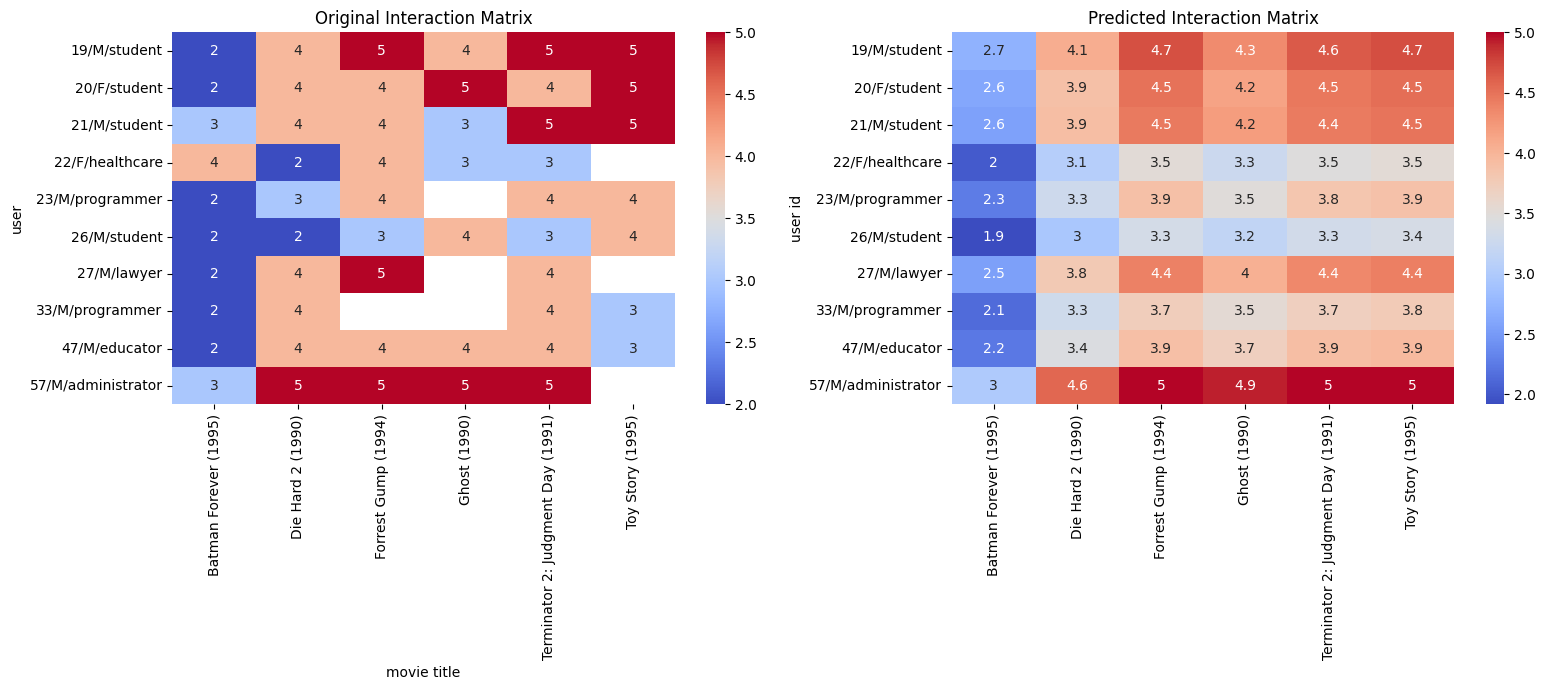

In [32]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

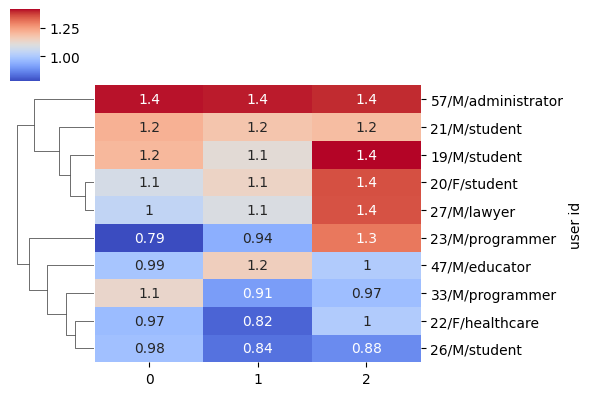

In [33]:
sns.clustermap(
    df_user_emb, annot=True, cmap=cmap_coolwarm, col_cluster=False, figsize=(6,4),
)
plt.show()

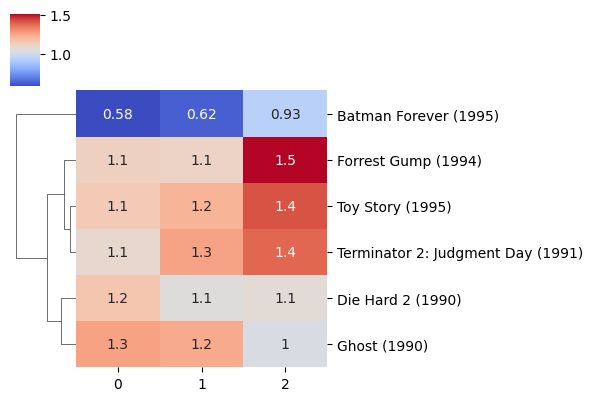

In [34]:
sns.clustermap(
    df_item_emb, annot=True, cmap=cmap_coolwarm, col_cluster=False, figsize=(6, 4),
)
plt.show()

## Tensorflow로 Matrix Factorization 모델 만들기: MovieLens 100K


Netflix Competition에서 1위 팀이 사용한 모델의 핵심 부분입니다.

[https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf](Matrix Factorization Techniques For Recommender)

$\hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

$\bar{r_u}$: 사용자의 상대적 평균(다른 사용자에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$\bar{r_i}$: 아이템의 상대적 평균(다른 아이템에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$ue_u \cdot ie_i$: 사용자와 아이템의 상호작용을 나타냅니다.

평균과 사용자의 평균 아이템의 평균과 함께 Matrix Factorization 모델을 사용하여,

Matrix Factorization 모델의 안정적으로 구성할 수 있었고, 

사용자와 아이템과 Rating과의 관계의 분석에 용이하게 됩니다.

ue: User Embedding, ie: Item Embedding

In [35]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

2025-03-19 09:47:09.718264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742345229.731778    1837 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742345229.735874    1837 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742345229.746349    1837 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742345229.746363    1837 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742345229.746365    1837 computation_placer.cc:177] computation placer alr

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1742345234.105286    1837 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [37]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    df_ratings, train_size=0.8, random_state=123, shuffle=True
)

In [38]:
df_train['user id'].value_counts()

user id
405    593
655    537
13     489
450    443
276    423
      ... 
310     14
558     14
36      14
876     14
866     13
Name: count, Length: 943, dtype: int64

In [39]:
# item_id와 user_id는 입력 변수이고 대상 변수는 rating은 Tensorflow Dataset을 만듭니다.
# Tensorflow 데이터셋을 사용하면 보다 안정적인 사용이 가능합니다.
# Tensorflow의 batch, shuffle 등 Dataset 처리를 활용할 수 있습니다.

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [40]:
# Tensorflow 데이터셋의 내용을 살펴 봅니다.

# batch_size 32개가 되도록하고, 첫 번째 배치만 출력합니다, 
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


### Matrix Factorization Model

$ue_u \cdot ie_i$

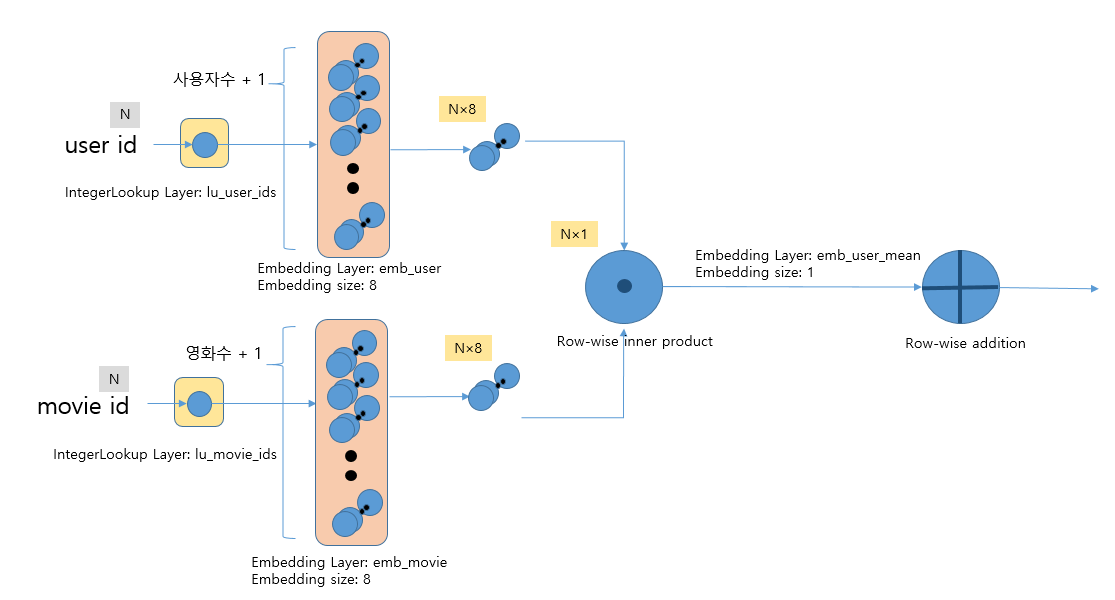

In [41]:
# IntegerLookup + Embedding 회상
voc = [100, 200, 300]
lu = tf.keras.layers.IntegerLookup(
    vocabulary = voc
)
emb_pos = lu(tf.constant([100, 200, 300, 400, 100]))
print(emb_pos)
emb = tf.keras.layers.Embedding(len(voc) + 1, 8)
emb_pos, emb(emb_pos)

tf.Tensor([1 2 3 0 1], shape=(5,), dtype=int64)


(<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 0, 1])>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.00914353, -0.04393603, -0.04500319,  0.0089858 ,  0.04343424,
          0.04695905,  0.02455777,  0.03392775],
        [-0.00637459, -0.0472752 , -0.00037528, -0.0444674 ,  0.04748205,
         -0.03924524, -0.04865132,  0.03861539],
        [-0.01710553, -0.01561204, -0.00561751, -0.01844859, -0.02946422,
         -0.00861641, -0.03318   ,  0.04323839],
        [-0.00317796, -0.037723  , -0.01659759, -0.01335384,  0.00408968,
          0.01004889, -0.01133008, -0.01462055],
        [ 0.00914353, -0.04393603, -0.04500319,  0.0089858 ,  0.04343424,
          0.04695905,  0.02455777,  0.03392775]], dtype=float32)>)

In [42]:
# 모델에서 사용하는 요소들을 Eager Execution 모드에서 제작합니다.
# 모델을 만드는 게 훨씬 수월해집니다.


# user id를 위치 Index로 바꿔주는 레이어입니다.
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['user id'].unique())
)
# 사용자 임베딩 레이어입니다.
emb_user = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 8
)

# item id를 위치 Index로 바꿔주는 레이어입니다. 
lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['item id'].unique())
)
# 아이템 임베딩 레이어입니다.
emb_movie = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 8
)

# Row-wise (axes=-1) Dot Product 레이어입니다.
dot = tf.keras.layers.Dot(axes=-1)

# user id를 임베딩에서의 위치 인덱스로 가져옵니다.
uid = lu_userid(tf.constant([1, 2, 0, -1, 5]))
print(uid)
# item id를 임베딩에서의 위치 인덱스로 가져옵니다.
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))
print(mid)
# 위치 인덱스에 해당하는 사용자 임베딩을 가져옵니다.
x_uid = emb_user(uid)
# 위치 인덱스에 해당하는 영화 임베딩을 가져옵니다.
x_mid = emb_movie(mid)

# 결과를 출력합니다.
x_uid, x_mid, dot([x_uid, x_mid])

tf.Tensor([ 52 116   0   0 431], shape=(5,), dtype=int64)
tf.Tensor([728 394 393 737 131], shape=(5,), dtype=int64)


(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.04438759, -0.01317178, -0.03386603,  0.03993448,  0.01417185,
         -0.01749646, -0.0259907 , -0.03330643],
        [-0.00420206,  0.01480692, -0.00682038, -0.04310166, -0.03350406,
          0.04955924,  0.01719004,  0.00483175],
        [ 0.01981649, -0.04513664,  0.00570537,  0.0278798 ,  0.0099481 ,
         -0.04078418, -0.03106054, -0.00026628],
        [ 0.01981649, -0.04513664,  0.00570537,  0.0278798 ,  0.0099481 ,
         -0.04078418, -0.03106054, -0.00026628],
        [-0.00938519, -0.01501272, -0.01148444, -0.02959641, -0.00155946,
          0.01781252,  0.03955603,  0.02697245]], dtype=float32)>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.0323086 ,  0.0110363 ,  0.02690286,  0.00095925, -0.02944927,
          0.02876124, -0.02012895, -0.04928578],
        [ 0.01496578,  0.03090593,  0.0468019 , -0.04237654,  0.02391387,
          0.00043001,  0.00846077, -0.0224107 ],
        [-0.0128408 ,  

### User/item mean Model 

$\bar{r} + \bar{r_u} + \bar{r_i}$

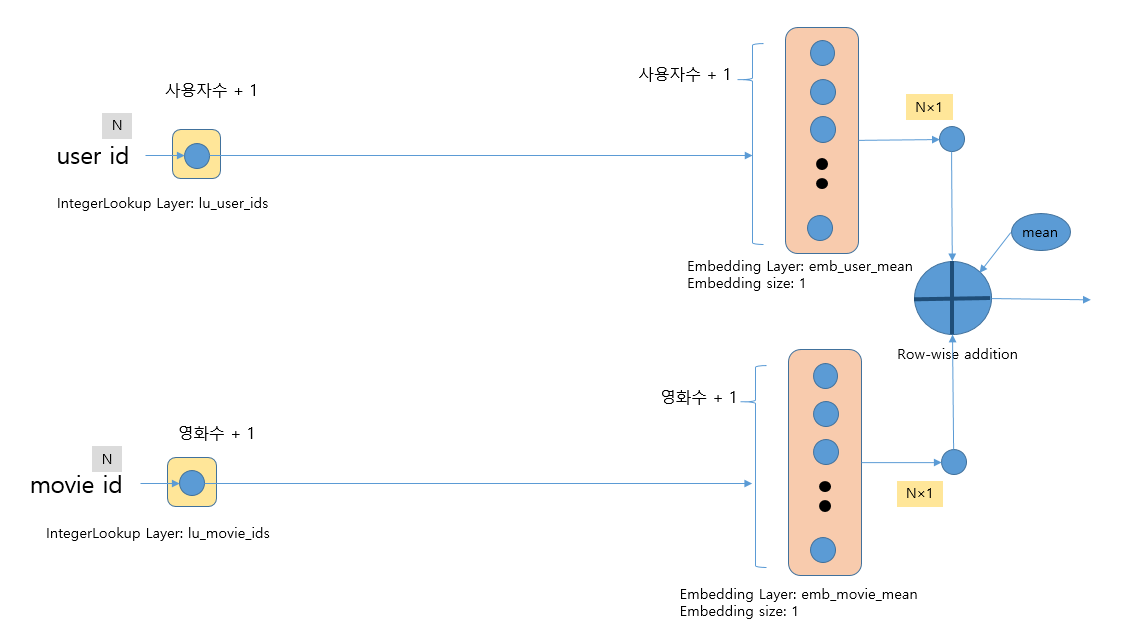

In [43]:
# 전체 평균을 구합니다.
mean = tf.constant([df_train['rating'].mean()], dtype=tf.float32)
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['user id'].unique())
)
# 사용자의 평균을 저장하는 임베딩입니다.
emb_user_mean = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 1
)

lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['item id'].unique())
)
# 영화의 평균을 저장하는 임베딩입니다.
emb_movie_mean = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 1
)

uid = lu_userid(tf.constant([1, 2, 0, 1, 5]))
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))

x_uid = emb_user_mean(uid)
x_mid = emb_movie_mean(mid)

x_uid, x_mid, x_uid + x_mid + mean

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.02713015],
        [-0.03341668],
        [-0.02711906],
        [-0.02713015],
        [-0.00556185]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.01184527],
        [-0.00491304],
        [-0.03134453],
        [-0.01844085],
        [ 0.00395142]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[3.490887 ],
        [3.4915328],
        [3.4713988],
        [3.4842913],
        [3.528252 ]], dtype=float32)>)

### Matrix Factorization augumented user/item mean Model

$\hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

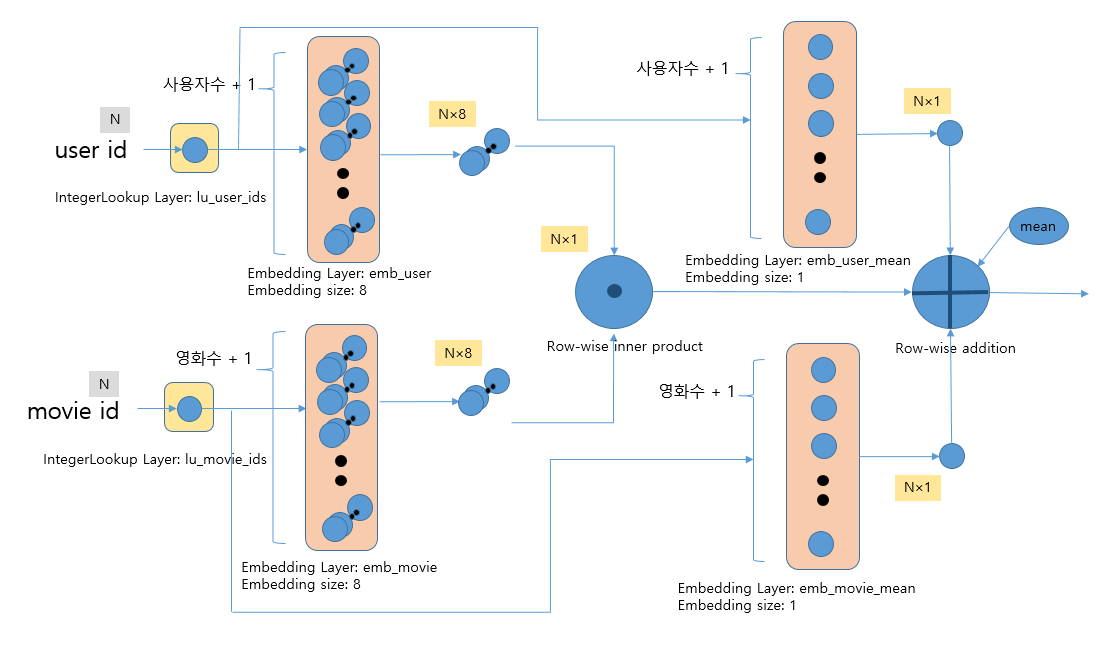

In [44]:
class MF_Mean_Model(tf.keras.Model):
    def __init__(self, user_ids, item_ids, rating_mean, rank):
        super().__init__()
        # user id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_user = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(user_ids)
        )
        # item id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_item = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(item_ids)
        )
        
        # user id에 대한 상대적 평균을 나타내는 임베딩입니다.
        self.emb_user_mean = tf.keras.layers.Embedding(len(user_ids) + 1, 1)
        # item id에 대한 상대적 평균을 나타내는 임베딩입니다. 
        self.emb_item_mean = tf.keras.layers.Embedding(len(item_ids) + 1, 1)
        
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. 사이즈는 rank 입니다
        self.emb_user = tf.keras.layers.Embedding(len(user_ids) + 1, rank)
        # 영화 행렬을 나타내는 사용자 임베딩입니다.
        self.emb_item = tf.keras.layers.Embedding(len(item_ids) + 1, rank)

        # 점수의 평균입니다. 상수 텐서로 상수인 float32 텐서로 저장합니다.
        self.rating_mean = rating_mean
        
        # 맵핑된 사용자 임베딩과 맵핑된 아이템 임베딩을 Row-wise inner product 연산을 해주는 layer입니다. 
        self.dot = tf.keras.layers.Dot(axes=-1)
        
    def call(self, X, training=False):
        x_user = self.lu_user(X['user id'])# 사용자 ID에서 임베딩의 위치 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) #사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        user_mean = self.emb_user_mean(x_user) # 사용자의 상대적 평균을 가져옵니다. user_mean: N×1 실수
        
        x_item = self.lu_item(X['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec =  self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        item_mean = self.emb_item_mean(x_item) # 아이템의 상대적 평균을 가져옵니다.
        
        return user_mean + item_mean + self.dot([user_vec, item_vec]) + self.rating_mean
    
    def predict_by_userid(self, user_id, item_ids):
        """
            call에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 예측 연산입니다.
            실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
            이러한 상황을 고려한 더욱 최적화한 루틴으로,
            한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        """
        
        x_user = self.lu_user([user_id]) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수
        # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
        # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
        x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
        item_vec = self.emb_item(x_item)
        return tf.squeeze(
            tf.matmul(item_vec, user_vec, transpose_b=True) + 
            self.emb_item_mean(x_item) +
            self.emb_user_mean(x_user) + 
            self.rating_mean
        ) 

In [45]:
# ds_train dataset에서 크기 32인 배치(Batch)로 나뉘도록 하고 하나의 배치셋만 출력해봅니다.
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


In [46]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 사용자 ID를 전달합니다. 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 아이템 ID를 전달합니다.
    df_train['rating'].mean(), 8
)

In [47]:
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam Optimizer를 사용합니다.
    loss=tf.keras.losses.MeanSquaredError(), # 손실은 MSE를 사용합니다.
    metrics=[tf.keras.metrics.MeanSquaredError()] # 지표는 MSE로 합니다.
)

In [48]:
# mf_mean_model을 ds_train 데이터셋으로 
# 100,000개 shuffle buffer ← 데이터가 입력 변수에 편향 되어 있을 경우 학습이 제대로 이루어지지 않습니다. 고루 섞일 수 있도록 shuffle buffer를 둡니다.
# 256개의 배치 사이스
# 20개의 epochs로 학습을 합니다.
# ds_test로 Epoch 마다 검증 하도록 합니다. (validation_data)
history = mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(256), epochs=20)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.2162 - mean_squared_error: 1.2162 - val_loss: 1.1483 - val_mean_squared_error: 1.1483
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.0876 - mean_squared_error: 1.0876 - val_loss: 1.0632 - val_mean_squared_error: 1.0632
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9971 - mean_squared_error: 0.9971 - val_loss: 1.0042 - val_mean_squared_error: 1.0042
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9364 - mean_squared_error: 0.9364 - val_loss: 0.9638 - val_mean_squared_error: 0.9638
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8930 - mean_squared_error: 0.8930 - val_loss: 0.9372 - val_mean_squared_error: 0.9372
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8551 - mean_squared_error: 0.8551 - val_loss: 0.9193 - val_mean_squared_error: 0.9193
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8283 - mean_squared_error: 0.8283 - val_loss: 0.90

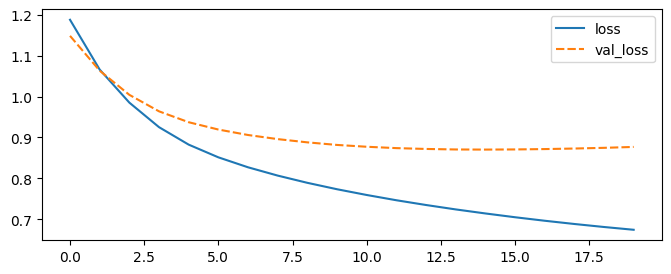

In [49]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

In [50]:
# 영화 임베딩을 3차원 공간에 투영하여 학습된 임베딩의 특성을 확인해봅니다.
import os

log_dir='logs/m100k/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# TSV로 만들면 영화 타이트을 투영시 보이게 할 수 있습니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index:
        f.write("{}\n".format(df_movie.loc[i, 'movie title']))

# 영화의 임베딩을 기록합니다.
weights =  tf.Variable(mf_mean_model.emb_item.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [73]:
# %tensorboard --logdir logs/m100k/ --bind_all

In [52]:
%%timeit
# 1번 사용자에 대해 모든 영화에 대한 평점 예측을 뽑는데 시간을 측정합니다.
# 모델으 호출 루틴은 user id, item id 를 건별로 입력 받게 되어 있습니다.
mf_mean_model({'user id': tf.constant([1] * len(df_movie)), 'item id': tf.constant(df_movie.index)})

8.51 ms ± 166 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%%timeit
# predict_by_userid 
mf_mean_model.predict_by_userid(1, df_movie.index)

7.78 ms ± 181 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
prd = mf_mean_model.predict(
    tf.data.Dataset.from_tensor_slices(
        {'user id': [1] * len(df_movie), 'item id': tf.constant(df_movie.index)}
    ).batch(128)
)
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10], :2]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,movie title,release date
movie id,,
50,Star Wars (1977),01-Jan-1977
127,"Godfather, The (1972)",01-Jan-1972
511,Lawrence of Arabia (1962),01-Jan-1962
483,Casablanca (1942),01-Jan-1942
318,Schindler's List (1993),01-Jan-1993
174,Raiders of the Lost Ark (1981),01-Jan-1981
64,"Shawshank Redemption, The (1994)",01-Jan-1994
172,"Empire Strikes Back, The (1980)",01-Jan-1980
199,"Bridge on the River Kwai, The (1957)",01-Jan-1957


In [65]:
df_ratings.query('`user id` == 1')[['item id', 'rating']].assign(
    title = lambda x: x['item id'].map(df_movie['movie title']),
    rating = lambda x: x['rating'].astype('int')
).groupby('rating').apply(
    lambda x: x[['title']].head(5), include_groups = False
).sort_index(level=0, ascending = False)

title
rating                                                        
5      2328                   Shawshank Redemption, The (1994)
       1440  Horseman on the Roof, The (Hussard sur le toit...
       1382                            Pillow Book, The (1995)
       687                                 Delicatessen (1991)
       639                                Groundhog Day (1993)
4      820                    Hunt for Red October, The (1990)
       478                           Angels and Insects (1995)
       334                          Glengarry Glen Ross (1992)
       333                                    Desperado (1995)
       202                          Three Colors: White (1994)
3      3733                                Crimson Tide (1995)
       3049                                True Romance (1993)
       1780                         From Dusk Till Dawn (1996)
       972                                    Rock, The (1996)
       305                             Grand Day Out, A (1992)
2      6212                         Room with a View, A (1986)
       4963                              101 Dalmatians (1996)
       4165                          Lawnmower Man, The (1992)
       4001                                    Bad Boys (1995)
       933                                Dirty Dancing (1987)
1      5141                                  Striptease (1996)
       4919      Homeward Bound: The Incredible Journey (1993)
       4070                               Event Horizon (1997)
       3248                Faster Pussycat! Kill! Kill! (1965)
       3171                          Kull the Conqueror (1997)

In [71]:
df_movie.iloc[:, :2].join(
    pd.Series(
        mf_mean_model.emb_item_mean.get_weights()[0][1:, 0], 
        index = df_train['item id'].value_counts().pipe(
            lambda x: x.loc[x > 20]
        ).index.values, 
        name = 'rating'
    )
).dropna().sort_values('rating', ascending = False)

,movie title,release date,rating
movie id,,,
408,"Close Shave, A (1995)",28-Apr-1996,0.764967
483,Casablanca (1942),01-Jan-1942,0.674040
169,"Wrong Trousers, The (1993)",01-Jan-1993,0.651825
603,Rear Window (1954),01-Jan-1954,0.639029
64,"Shawshank Redemption, The (1994)",01-Jan-1994,0.629407
...,...,...,...
988,"Beautician and the Beast, The (1997)",07-Feb-1997,-0.833483
688,Leave It to Beaver (1997),22-Aug-1997,-0.865532
368,Bio-Dome (1996),01-Jan-1996,-0.866677


## NNModel

**Neural Networks Architecture**

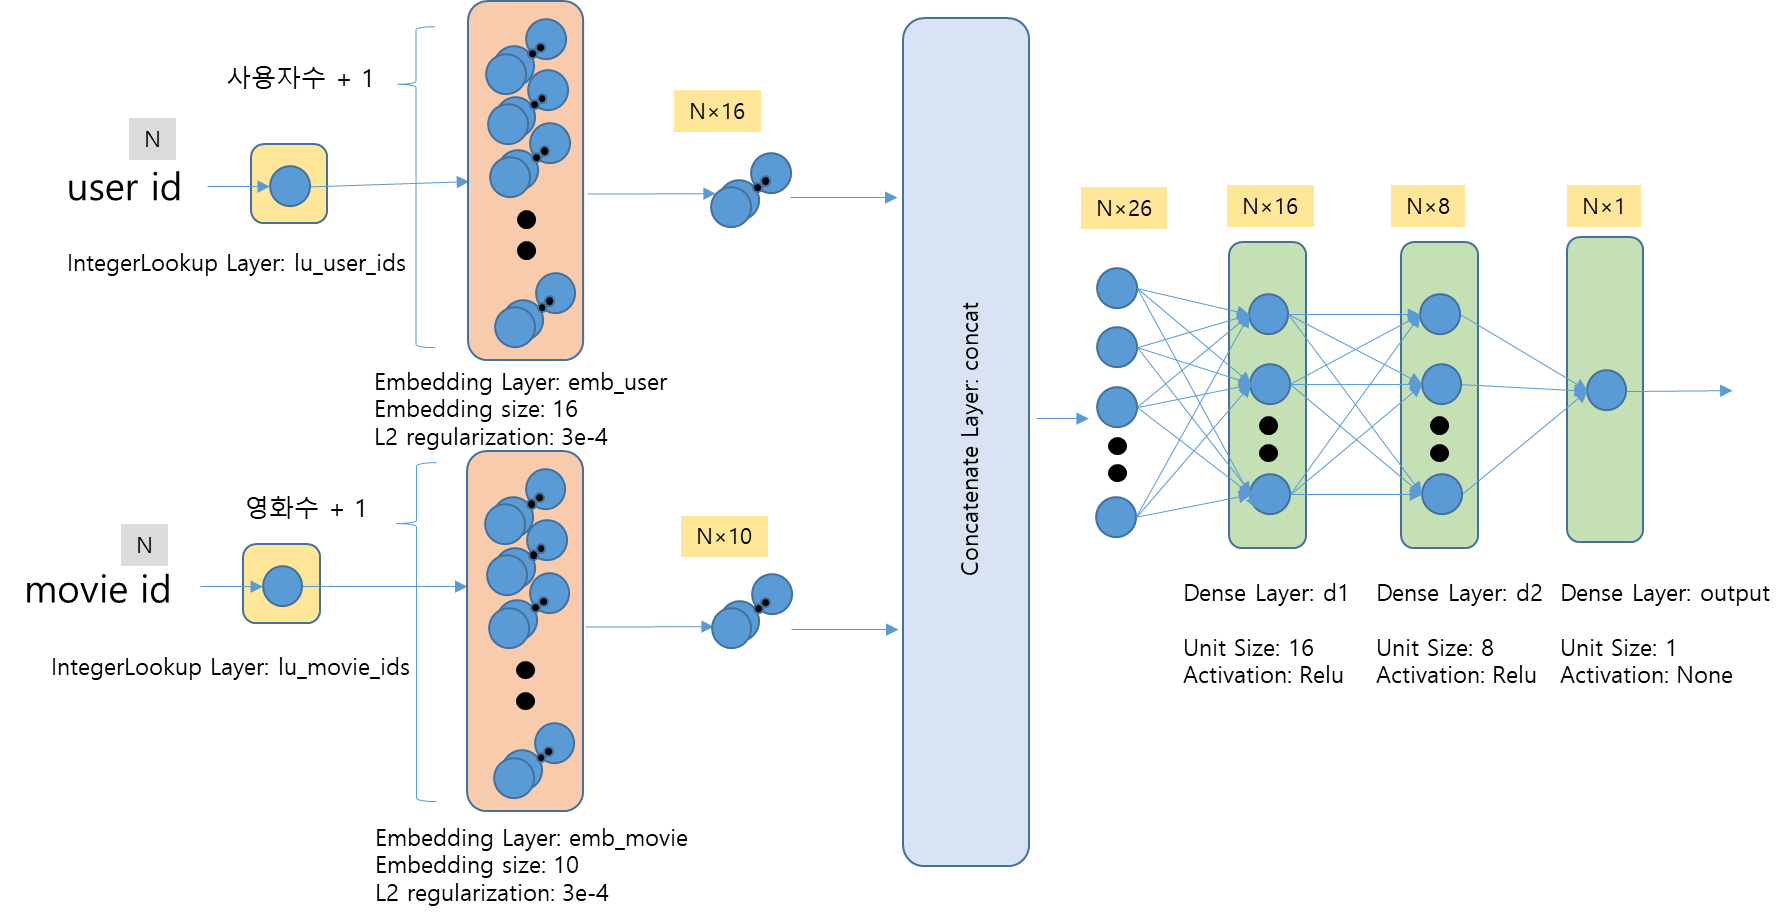

In [57]:
class NNModel(tf.keras.Model):
    def __init__(self, user_ids, item_ids, emb_user_size, emb_item_size):
        super().__init__()
        self.lu_user = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(user_ids)
        )
        self.lu_item = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(item_ids)
        )
        
        self.emb_user =  tf.keras.layers.Embedding(
            len(user_ids) + 1, emb_user_size
        )
        self.emb_item =  tf.keras.layers.Embedding(
            len(item_ids) + 1, emb_item_size
        )
        
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        
        self.dl1 = tf.keras.layers.Dense(16, activation = 'relu', kernel_initializer = 'he_uniform')
        self.dl2 = tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer = 'he_uniform')
        self.o = tf.keras.layers.Dense(1, kernel_initializer = 'glorot_uniform')
        
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id']) # 사용자 ID에서 임베딩의 위치 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        x_item = self.lu_item(x['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec = self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        x = self.cc([user_vec, item_vec])
        x = self.dl1(x) # dense layer 1 
        x = self.dl2(x) # dense layer 2
        return self.o(x) # output layer

In [58]:
nn_model = NNModel(
    df_train['user id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['item id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    16, 10
)

In [60]:
tf.keras.backend.clear_session()
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)
history = nn_model.fit(ds_train.shuffle(10000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.8607 - mean_squared_error: 0.8607 - val_loss: 1.0053 - val_mean_squared_error: 1.0053
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8548 - mean_squared_error: 0.8548 - val_loss: 1.0064 - val_mean_squared_error: 1.0064
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8501 - mean_squared_error: 0.8501 - val_loss: 1.0084 - val_mean_squared_error: 1.0084
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8488 - mean_squared_error: 0.8488 - val_loss: 1.0073 - val_mean_squared_error: 1.0073
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8442 - mean_squared_error: 0.8442 - val_loss: 1.0129 - val_mean_squared_error: 1.0129
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8397 - mean_squared_error: 0.8397 - val_loss: 1.0100 - val_mean_squared_error: 1.0100
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.8326 - mean_squared_error: 0.8326 - val_los

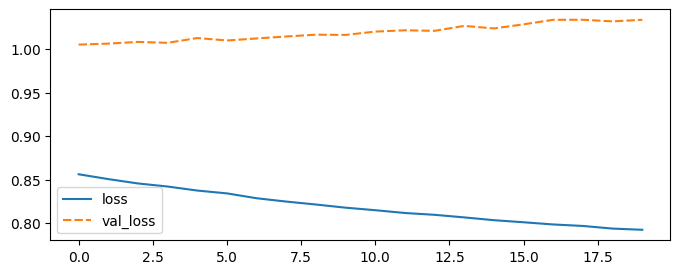

In [61]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

**VS Neural Network**

**Matrix Factorization**: 사용자 한 명의 영화에 대한 예측은 한 번의 모델 실행으로 구할 수 있습니다.

따라서, Matrix Factorization은 Neural Network 보다 서비스 시 빠릅니다. => **Matrix Factorization은 빠릅니다.**

※ Google에서 개발한 ScaNN과 같은 알고리즘 이 과정을 보다 최적화시켜 줍니다.

하지만, Matrix는 사용자와 아이템을 동일한 사이즈(Rank)로 구성해야 하는 **구조적 제약**을 가지고 있어

Neural Network에 비해 Network 구성을 하는데에는 제약을 가지고 있습니다. 

이로 인해 **정교한 모델링이 Neural Network보다 어렵습니다.**

이 둘을 활용하는 전략에 대해 아래 논문이 자세히 다루고 있습니다.

[Youtube Recommender](https://github.com/Dryjelly/Youtube_Recommendation_tf_keras)

논문의 골자: 

Matrix Factorization은 추천 아이템을 1차적으로 후보 대상을 선정하여 예측 대상을 줄이고,

Nerual Network을 통해 정교한 예측 결과로 순위를 메기는 구조로

추천 시스템을 구성한다는 것입니다.

[Tensorflow Recommender](https://www.tensorflow.org/recommenders)

In [75]:
%%timeit
mf_mean_model.predict_by_userid(1,  tf.constant(df_movie.index))

7.69 ms ± 212 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Neural Network**: 사용자 한 명의 영화에 대한 예측을 구하려면 예측할 영화의 개수 만큼 모델을 실행해야 합니다.

In [76]:
%%timeit
X = tf.data.Dataset.from_tensor_slices({
    'user id': [1] * len(df_movie),
    'item id': df_movie.index.values
}).batch(2048)

nn_model.predict(X, verbose=0)

13.8 ms ± 79.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* 하지만 구조상 User와 Item 을 동일한 수의 임베딩으로 모델링해야 한다는 구조적 제약이 있어 Neural Network 보다는 모델 유연한 구성이 힘듭니다.

* Neural Network는 Matrix Factorization 보다는 느리지만, 다양한 입력 변수를 수용할 수 있고, 구조에 유연성을 지녀 Matrix Factorization 보다 정확한 예측 결과를 낼 수 있습니다.


# 문제점

Matrix Factorization 모델 뿐만 아니라, 데이터 기반의 방법에서의 문제점이기도 합니다.

## 1. Cold Start Problem

데이터가 확보되지 않은 사용자나 아이템에 대한 예측의 정확도가 떨어집니다.

In [77]:
# 시점을 기준으로 나누어 Test에는 Train에 등장하지 않은 사용자와 영화가 배치되도록 합니다.
df_train = df_ratings.query('date < "1998-03-01"')
df_test = df_ratings.query('date >= "1998-03-01"')

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [80]:
# Train에 등장하지 않은 사용자의 출연 빈도를 봅니다.
df_test['user id'].value_counts().pipe(
    lambda x: x.loc[~x.isin(df_train['user id'].unique())]
)

user id
234    480
796    358
551    334
334    333
393    234
      ... 
483      3
640      3
145      3
561      3
768      3
Name: count, Length: 75, dtype: int64

In [82]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['rating'].mean(), 
    16
)
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [83]:
history = mf_mean_model.fit(
    ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(1024), epochs=20
)

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1371 - mean_squared_error: 1.1371 - val_loss: 1.1380 - val_mean_squared_error: 1.1380
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8480 - mean_squared_error: 0.8480 - val_loss: 1.1263 - val_mean_squared_error: 1.1263
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7339 - mean_squared_error: 0.7339 - val_loss: 1.1437 - val_mean_squared_error: 1.1437
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6513 - mean_squared_error: 0.6513 - val_loss: 1.1890 - val_mean_squared_error: 1.1890
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5970 - mean_squared_error: 0.5970 - val_loss: 1.2021 - val_mean_squared_error: 1.2021
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5508 - mean_squared_error: 0.5508 - val_loss: 1.2405 - val_mean_squared_error: 1.2405
Epoch 7/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5249 - mean_squared_error: 0.5249 - val_loss: 1.26

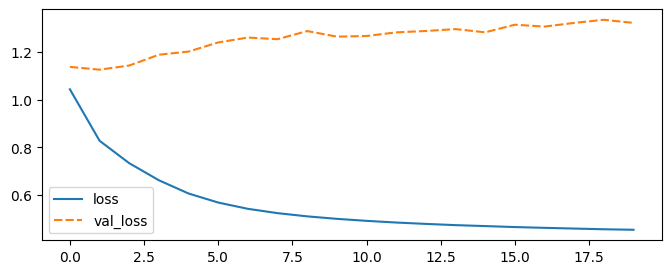

In [84]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

In [85]:
# 사용자가 Train에 등장 빈도수별로 성능을 측정하기 위해
# 사용자별 MSE를 구합니다.
s_mse = df_test.assign(
    rating_hat = np.squeeze(mf_mean_model.predict(ds_test.batch(1024)))
).groupby('user id').apply(lambda x: mean_squared_error(x['rating'], x['rating_hat']), include_groups=False).rename('mse')
s_mse

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


user id
1      1.643227
2      1.433702
3      2.334541
4      1.401945
7      1.543501
         ...   
932    1.133791
934    1.160913
938    1.590748
940    2.550335
942    1.126642
Name: mse, Length: 327, dtype: float64

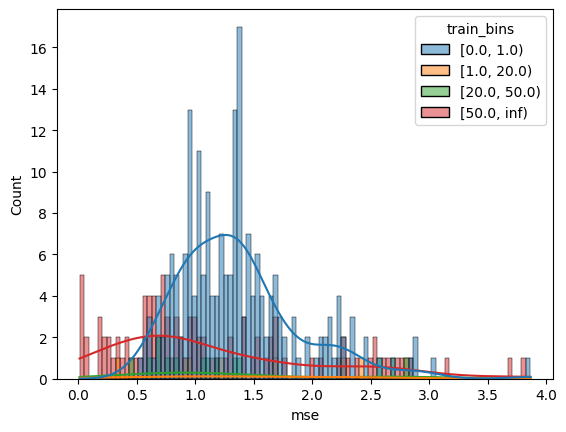

In [86]:
pd.concat([
    df_train['user id'].value_counts().rename('train count'),
    df_test['user id'].value_counts().rename('test count'), s_mse
], axis=1).pipe(lambda x: x.loc[x['test count'].notna()]).fillna(0)\
.assign(
    train_bins = lambda x: pd.cut(x['train count'], bins=[0, 1, 20, 50, np.inf], right=False)
).pipe(lambda x: sns.histplot(data=x, x='mse', hue='train_bins', bins=100, kde=True))
plt.show()

## 2. 지속적인 재학습 필요

사용자, 아이템이 추가될 때마다, 모델을 재구성해줘야 하고

새로운 데이터로 재학습을 시켜줘야합니다.

이후 챕터에서는 이를 극복하기 위한 방법을 소개드립니다.